In [1]:
import pandas as pd
import datetime as datetime
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv("BTC_USDT_1m.csv").drop(["Unnamed: 0"],axis=1)
data.head()

,datetime,open,high,low,close,volume
0,2017-12-31 15:00:00,13328.28,13337.94,13306.01,13320.00,6.968367
1,2017-12-31 15:01:00,13320.00,13337.94,13300.00,13313.30,14.857871
2,2017-12-31 15:02:00,13313.30,13313.30,13280.00,13305.01,10.268893
3,2017-12-31 15:03:00,13313.30,13334.00,13301.27,13334.00,12.516135
4,2017-12-31 15:04:00,13314.00,13346.60,13310.02,13325.01,13.362592


In [7]:
def checking_labeling(labeling_data):
    step = 1000
    for i in range(0, len(labeling_data) - step, step):
        name = str(labeling_data.iloc[i]["datetime"])+ " ~ " + str(labeling_data.iloc[i + step - 1]["datetime"])
        fig = plt.figure(figsize=(16,9))
        fig = plt.title(name)
        fig = plt.plot(labeling_data.iloc[i:i + step]["datetime"], labeling_data.iloc[i:i + step]["close"])
        for j in range(i, i + step):
            if labeling_data.iloc[j]["label"] == 0:
                fig = plt.scatter(labeling_data.iloc[j]["datetime"], labeling_data.iloc[j]["close"], color = "r")
            if labeling_data.iloc[j]["label"] == 1:
                fig = plt.scatter(labeling_data.iloc[j]["datetime"], labeling_data.iloc[j]["close"], color = "b")
        
        plt.savefig("Labeling_picture/" + name + ".png")

In [4]:
class DataLabeling:
    POSITIVE = math.inf
    NEGATIVE = -math.inf
    def __init__(self,data, lookahead_range, target_price,term = 10,alpha = 0.002):
        self.lookahead_range = lookahead_range
        self.data = data   
        self.target_price = target_price
        self.term = term
        self.alpha = alpha

    # lookahead_range 범위안에 더 큰 값이 있는지 확인하는 함수
    def find_max(self,idx):
        for i in range(idx+1,idx + self.lookahead_range + 1):
            if self.data.iloc[i][self.target_price] > self.data.iloc[idx][self.target_price]:
                return False
        return True

    # lookahead_range 범위안에 더 작은 값이 있는지 확인하는 함수
    def find_min(self,idx):
        for i in range(idx+1,idx + self.lookahead_range + 1):
            if self.data.iloc[i][self.target_price] < self.data.iloc[idx][self.target_price]:
                return False
        return True
    def ck(self,idx,term,len_data):
        if idx - term >= 0 and idx + term + 1 < len_data:
            return term
        elif idx - term < 0:
            return idx
        elif idx + term + 1 > len_data:
            return 0
        
    def low_high_vicinity(self,low_label, high_label):
        temp = [2 for i in range(len(self.data))]
        self.data.loc[:, 'label'] = temp
        
        for i in range(len(low_label)):
            idx = low_label[i][0]
            self.data.loc[idx,"label"] = 1
            temp_term = self.ck(idx,self.term,len(self.data))
            low_price = self.data.iloc[idx]["close"]
            
            for j in range(idx-temp_term, idx + temp_term + 1):
                try:
                    if self.data.iloc[j]["close"] < low_price + low_price * self.alpha:
                        self.data["label"][j] = 1
                except IndexError:
                    print("Index out of bounds:",j,idx)


        for i in range(len(high_label)):
            idx = high_label[i][0]
            self.data.loc[idx,"label"] = 0

            temp_term = self.ck(idx,self.term,len(self.data))
            high_price = self.data.iloc[idx]["close"]
            
            for j in range(idx-temp_term, idx + temp_term + 1):
                if self.data.iloc[j]["close"] > high_price - high_price * self.alpha:
                    self.data["label"][j] = 0

    def test(self,high_range,low_range):
        temp = [0 for i in range(len(self.data))]
        self.data['label'] = temp
        
        # fig = plt.figure(figsize=(25,14))
        # fig = plt.plot(self.data.close,color = 'black')
        # 상승구간 0, 하락구간 1
        # 저점 먼저 시작
        if high_range[0][0] > low_range[0][0]:
            for i in tqdm(range(len(high_range))):
                for j in range(2):
                    if i == len(high_range)-1 and j == 1:
                        break
                    if j == 0:
                        idx = [self.data.index[k] for k in range(low_range[i+j][0],high_range[i][0] + 1)]
                        self.data.loc[idx,['label']] = 0
                    else:
                        idx = [self.data.index[k] for k in range(high_range[i][0], low_range[i+j][0] + 1)]
                        self.data.loc[idx,['label']] = 1
        # 고점 먼저 시작
        else:
            for i in tqdm(range(len(low_range))):
                for j in range(2):
                    if i == len(low_range)-1 and j == 1:
                        break
                    if j == 0:
                        idx = [self.data.index[k] for k in range(high_range[i+j][0],low_range[i][0] + 1)]
                        self.data.loc[idx,['label']] = 1
                    else:
                        idx = [self.data.index[k] for k in range(low_range[i][0], high_range[i+j][0] + 1)]
                        self.data.loc[idx,['label']] = 0
    def StartSearching(self):

        # lookahead_range 범위안에서 가장 작은 값과 큰 값의 인덱스 값
        max_index = self.data[self.data[self.target_price] == max(self.data[self.target_price][:self.lookahead_range])].index[0]
        min_index = self.data[self.data[self.target_price] == min(self.data[self.target_price][:self.lookahead_range])].index[0]

        # 숫자로 된 인덱스를 구함
        max_num = [i for i in range(len(self.data)) if max_index == self.data.index[i]][0]
        min_num = [i for i in range(len(self.data)) if min_index == self.data.index[i]][0]
        
        # 만약 고점이 더 늦게 나왔다면 현재 고점부터 먼저 시작 알고리즘 
        if max_index > min_index:
            ck,start = 1,max_num

            # 하지만 lookahead_range 범위 앞에 더 큰 값이 있으면 저점 부터 시작 알고리즘
            if not self.find_max(max_num):
                ck,start = 0,min_num

        elif min_index > max_index:
            ck,start = 0,min_num

            if not self.find_min(min_num):
                ck,start = 1,max_num

        return ck,start
    def find_max(self,idx):
        for i in range(idx+1,idx + self.lookahead_range + 1):
            if self.data.iloc[i][self.target_price] > self.data.iloc[idx][self.target_price]:
                return False
        return True
    def find_min(self,idx):
        for i in range(idx+1,idx + self.lookahead_range + 1):
            if self.data.iloc[i][self.target_price] < self.data.iloc[idx][self.target_price]:
                return False
        return True
    def run(self):
        # ck : 고점 or 저점 시작 여부(0, 1), start_num : 고점 or 저점 시작 인덱스(int)
        ck, start_num = self.StartSearching()

        high_label = [] # 고점들의 리스트
        low_label = [] # 저점들의 리스트
        line = [] # 각 리스트 2차원 리스트

        
        if ck == 0: # 고점을 찾는다
            line.append(start_num)
            line.append(self.data.index[start_num])
            low_label.append(line)

            previous_min = self.data.iloc[start_num][self.target_price]
            max = self.data.iloc[start_num][self.target_price]
            min = self.POSITIVE
        else:
            line.append(start_num)
            line.append(self.data.index[start_num])
            high_label.append(line)
            
            previous_max = self.data[self.target_price][start_num]
            min = self.data[self.target_price][start_num]
            max = self.NEGATIVE

            curr_index = 0

        for i in tqdm(range(start_num, len(self.data) - self.lookahead_range)):
            line = []
            if ck == 0:
                if self.data.iloc[i][self.target_price] > max and self.data.iloc[i][self.target_price] >= previous_min: # 만약 현재 인덱스 값이 max보다 클시
                    if self.data.iloc[i + 1:i + self.lookahead_range + 1][self.target_price].max() < self.data.iloc[i][self.target_price]: # 만약에 앞에 term일 동안 더 큰 값이 없으면 고점이라고 판단
                        line.append(i)
                        line.append(self.data.index[i])
                        high_label.append(line)

                        previous_max = self.data.iloc[i][self.target_price]
                        max = self.NEGATIVE
                        ck = 1

                        curr_index = i
                    elif not self.find_max(i): # 만약 앞에 term일 동안 더 큰 값이 있으면 고점이 아님 , max값만 업데이트
                        max = self.data.iloc[i][self.target_price]
            elif ck == 1: # 저점을 찾는다.
                if self.data.iloc[i][self.target_price] < min and self.data.iloc[i][self.target_price] <= previous_max:
                    if self.data.iloc[i+1:i+self.lookahead_range+1][self.target_price].min() > self.data.iloc[i][self.target_price]:
                        line.append(i)
                        line.append(self.data.index[i])
                        low_label.append(line)
                        
                        previous_min = self.data.iloc[i][self.target_price]
                        min = self.POSITIVE
                        ck = 0

                        curr_index = i
                    elif not self.find_min(i):
                        min = self.data.iloc[i][self.target_price]
        # curr_index : 마지막 라벨 인덱스
        last_index = -1

        # 라벨 체크를 다하고 남은 데이터에 대한 처리
        for i in tqdm(range(curr_index,len(self.data))):
            
            if self.data.iloc[i][self.target_price] == max:
                last_index = i
            
            elif self.data.iloc[i][self.target_price] == min:
                last_index = i
            
            elif self.data.iloc[i][self.target_price] > max and ck == 0:
                last_index = i
                max = self.data.iloc[i][self.target_price]
            
            elif self.data.iloc[i][self.target_price] < min and ck == 1:
                last_index = i
                min = self.data.iloc[i][self.target_price]
            
        if ck == 0:
            line.append(last_index)
            line.append(self.data.index[last_index])
            high_label.append(line)
        else:
            line.append(last_index)
            line.append(self.data.index[last_index])
            low_label.append(line)
        self.low_high_vicinity(low_label,high_label)

In [8]:
object = DataLabeling(data,60,"close",alpha=0)
object.run()

100%|██████████| 105/105 [00:00<00:00, 1605.21it/s]


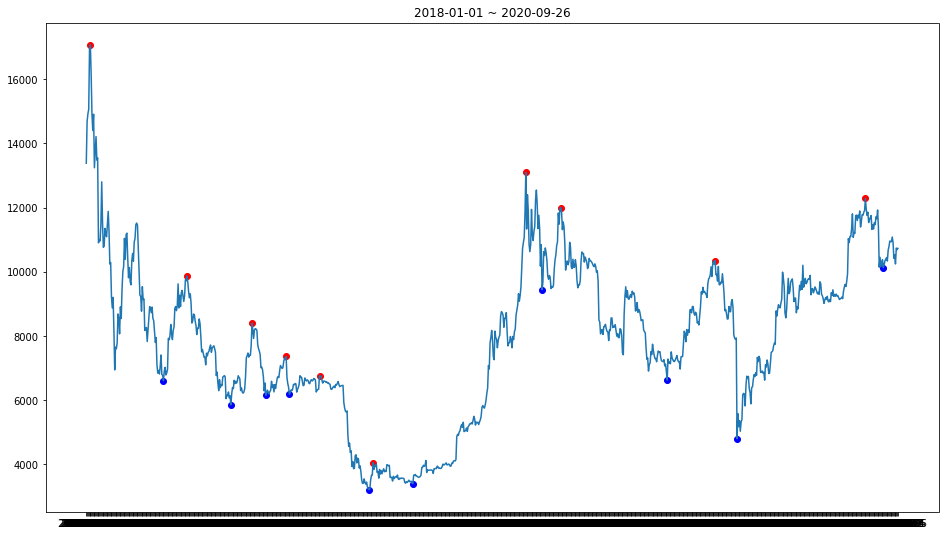

In [9]:
checking_labeling(object.data)

In [8]:
object.data.to_csv("testlabel.csv")

In [ ]:
object = DataLabeling(data.iloc[:10000],120,"close")
low_label, high_label = object.run()

In [ ]:
df = data.iloc[:10000]
temp = [-1 for i in range(len(df))]
df.loc[:, 'label'] = temp
term = 10
a = 0.002
def ck(idx,term,len_data):
    if idx - term >= 0 and idx + term + 1 < len_data:
        return term
    elif idx - term < 0:
        return idx
    elif idx + term + 1 > len_data:
        return 0
    
for i in range(len(low_label)):
    idx = low_label[i][0]
    df.loc[idx,"label"] = 0
    term = ck(idx,term,len(df))
    low_price = df.iloc[idx]["close"]
    
    for j in range(idx-term, idx + term + 1):
        try:
            if df.iloc[j]["close"] < low_price + low_price * a:
                df["label"][j] = 0
        except IndexError:
            print("Index out of bounds:",j,idx)


for i in range(len(high_label)):
    idx = high_label[i][0]
    df.loc[idx,"label"] = 1

    term = ck(idx,term,len(df))
    high_price = df.iloc[idx]["close"]
    
    for j in range(idx-term, idx + term + 1):
        if df.iloc[j]["close"] > high_price - high_price * a:
            df["label"][j] = 1

In [ ]:
df.label.value_counts()

In [ ]:
df

In [ ]:
checking_labeling(df)